# Create animations

- Plot individual `png` snapshots and then use `ffmpeg` to make a nice video

In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tifffile as tf
import os
import json
import pandas as pd
from scipy import ndimage
import utils

In [2]:
colors = ['#ddcc77', '#117733','#aa4499', '#88ccee', '#CC6677', '#44aa99']
markers = ['s','D','o','^','v','<','>','*']
buffx = 0
buffX = 1475
buffy = 200
buffz = 50
nsamples = 5
pxmm = 28
llen = 175

isrc = '../raw/'
rsrc = '../reference/'
ssrc = '../proc/skel/'
dst = '../proc/anim/'
time = '4pm'
rep = 7

infodicts = [dict() for i in range(nsamples)]
for pidx in range(nsamples):
    filename = ssrc + '{}_rep{}/{}_rep{}_plant_{:02d}_posang.json'.format(time, rep, time, rep, pidx)
    with open(filename) as f:
        d = json.load(f)
    for key in d:
        d[key] = np.array(d[key])
    infodicts[pidx] = d

maxdict = np.zeros((nsamples, 4))
for pidx in range(nsamples):
    info = infodicts[pidx]
    j = 0
    for col in ['mang','mpos']:
        vals = np.hstack([info['{}_{}'.format(col, i+1)] for i in range(len(info['bookends']))])
        maxdict[pidx, j:j+2] = [np.min(vals), np.max(vals)]
        j += 2

maxdict[:, :2] = np.rad2deg(maxdict[:,:2])
maxdict[:, 2:] = maxdict[:, 2:]/28

meta = pd.read_csv(rsrc + 'reference_positions_{}_rep{}.csv'.format(time, rep))
meta = meta.set_index('numidx')

skeletons = [ dict() for j in range(nsamples) ]
for pidx in range(nsamples):
    for idx in meta.index:
        filename = ssrc + '{}_rep{}/plant_{:02d}/{}_rep{}_p{:02d}_{:04d}.csv'.format(time, rep, pidx, time, rep, pidx, idx)
        skeletons[pidx][idx] = np.loadtxt(filename, dtype=int, delimiter=',')

maxvals = np.zeros((nsamples, len(meta), 4), dtype=int)
for pidx in range(1, nsamples):
    for i,idx in enumerate(meta.index):
        foo = skeletons[pidx][idx][1] - ( meta.loc[idx]['peaks_{}'.format(pidx)] - meta.loc[idx]['peaks_{}'.format(pidx-1)] - buffz)
        maxvals[pidx, i, 0] = np.min(skeletons[pidx][idx][0])
        maxvals[pidx, i, 1] = np.max(skeletons[pidx][idx][0])
        maxvals[pidx, i, 2] = np.abs(np.min([np.min(foo), 0]))
        maxvals[pidx, i, 3] = np.max([np.max(foo),0])
pidx = 0
for i,idx in enumerate(meta.index):
    foo = skeletons[pidx][idx][1] - meta.loc[idx]['peaks_{}'.format(pidx)]
    maxvals[pidx, i, 0] = np.min(skeletons[pidx][idx][0])
    maxvals[pidx, i, 1] = np.max(skeletons[pidx][idx][0])
    maxvals[pidx, i, 2] = np.abs(np.min([np.min(foo), 0]))
    maxvals[pidx, i, 3] = np.max([np.max(foo),0])

alpha = 0.025
pad = 25
topbot = np.zeros((nsamples, 2), dtype = int)
for pidx in range(nsamples):
    topbot[pidx] = [max([np.quantile(maxvals[pidx, :,0], alpha) - pad, 0]) , 
                    min([np.quantile(maxvals[pidx, :,1], 1-alpha) + pad, min(meta['tapes_{}'.format(pidx)])])]

adjustby = np.diff(topbot, axis=1).squeeze() - np.mean(np.diff(topbot, axis=1)).astype(int) - pad
adjustby[adjustby < 0 ] = 0
topbot[:,0] += adjustby

yticks = [None for pidx in range(nsamples)]
ylims = np.zeros((nsamples, 2))
for pidx in range(nsamples):
    tape = np.min(meta['tapes_{}'.format(pidx)])
    minit = (tape - topbot[pidx,1] + pad)//pxmm+2
    mfin = (tape - topbot[pidx,0] - pad)//pxmm
    ylabs = np.arange(minit, mfin+1, 4)
    yvals = tape - ylabs*pxmm
    yticks[pidx] = np.vstack((yvals,ylabs))
    ylims[pidx] = [(tape - topbot[pidx,1])/pxmm, (tape - topbot[pidx,0])/pxmm]

meta.tail()

,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,tapes_0,tapes_1,tapes_2,tapes_3,tapes_4,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
numidx,,,,,,,,,,,,,,,,,,,,
898,589,1296,2062,2923,3755,887,974,977,1168,1373,226.013,181.650,191.192,180.394,189.944,-0.014505,0.018464,0.001423,0.013669,0.014509
899,588,1292,2063,2924,3769,887,976,976,1168,1372,226.815,206.645,190.170,179.839,181.746,-0.014473,-0.002839,0.001395,0.012945,0.008487
900,600,1298,2070,2915,3760,889,975,976,1201,1372,217.138,192.714,185.207,187.165,188.112,-0.016655,0.005185,0.000124,0.014584,0.011612
901,590,1294,2069,2917,3759,888,975,976,1169,1371,227.090,205.359,187.053,185.691,188.393,-0.014044,-0.001796,-0.000399,0.014074,0.011150
902,595,1289,2069,2922,3762,888,976,975,1168,1372,221.687,209.709,186.459,182.117,186.465,-0.015460,-0.002556,-0.000502,0.012487,0.011103


In [15]:
idx = 1
filename = glob(isrc + time + '*{}/*{}*({})*'.format(rep,rep,idx))[0]
raw = cv2.imread(filename)[:,:,::-1]
n, lines, xvals, plants = utils.get_img_metadata(meta, idx, nsamples, buffx, buffX, buffy, buffz)

In [19]:
pidx = 4
xlen, line, b = utils.get_plant_metadata(pidx, plants, xvals, lines, n)
peak = int(np.mean(line))
tape = np.min(meta['tapes_{}'.format(pidx)])

upperleft=[topbot[pidx,0], peak - np.max(maxvals[pidx, :, 2]) - pad]
lowerright=[topbot[pidx,1], peak + np.max(maxvals[pidx, :, 3]) + pad]
skeleton = skeletons[pidx][idx]
info = infodicts[pidx]
rows = idx - info['bookends'][:, 0]

posang = np.zeros((np.sum(rows >= 0), 2))
for i in range(len(posang)):
    posang[i] = [ xlen[-1] - info['mpos_{}'.format(i+1)][rows[i]] , info['mang_{}'.format(i+1)][rows[i]] ]

data = [None for i in range(len(posang))]
for i in range(len(data)):
    data[i] = [ info['{}_{}'.format(col, i+1)][:rows[i] + 1] for col in ['mang','mpos'] ]
    data[i][0] = np.rad2deg(data[i][0])
    data[i][1] = data[i][1].astype(float)/28

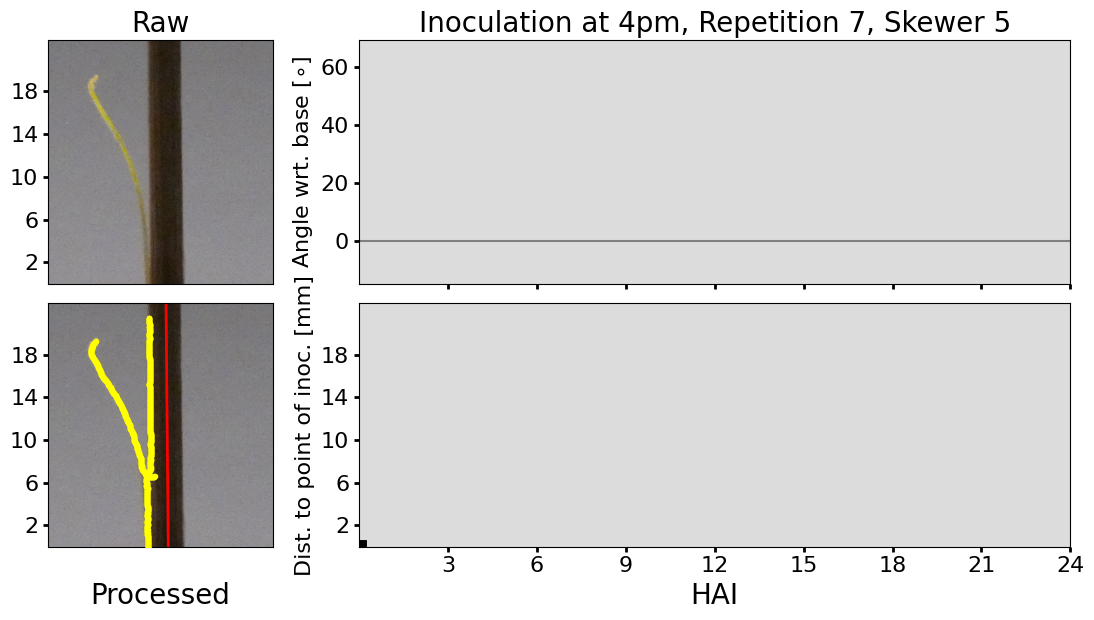

In [20]:
FS,fs = 20,16

fig = plt.figure(layout='tight', figsize=(11.25,6.3))
gs = GridSpec(2,3, figure=fig)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,1:])
ax3 = fig.add_subplot(gs[1,1:])
ax = [ax0, ax1, ax2, ax3]

ax[1].scatter(skeleton[1], skeleton[0], c='yellow', marker='.', zorder=3)
ax[1].plot(line, xlen, c='r', lw=2, zorder=2)
    
for i in range(len(posang)):
    xy1 = (line[int(posang[i,0])], posang[i,0])
    m = -np.tan(posang[i,1])
    b = xy1[1] - m*xy1[0]
    x = np.array([xy1[0]-llen, xy1[0]+llen])
    ax[1].plot(x, m*x+b, c=colors[i+3], lw = 3, zorder=4)
    ax[1].scatter(*xy1, c='w', s=150, marker='*', zorder=5, edgecolor='k', linewidths=1)

for i in [0,1]:
    ax[i].imshow(raw[plants[pidx]], origin='upper', zorder=1)
    ax[i].set_aspect('equal')
    ax[i].margins(x=0.5, y=0)
    ax[i].set_facecolor('gray')
    ax[i].set_xlim(upperleft[1], lowerright[1])
    ax[i].set_ylim(lowerright[0], upperleft[0])
    ax[i].set_yticks(*yticks[pidx])
    ax[i].tick_params(left=True, labelleft=True, bottom=False, labelbottom=False, width=2, labelsize=fs)

ax[2].tick_params(bottom=True, labelbottom=False, width=2, labelsize=fs)
ax[3].tick_params(bottom=True, labelbottom=True, width=2, labelsize=fs)

ax[2].set_ylim(min([-5, maxdict[pidx,0]-5]), maxdict[pidx,1]+5)
ax[3].set_ylim(*ylims[pidx])
ax[3].plot([0, idx*2/75], [ylims[pidx,0], ylims[pidx,0]], lw=10, c='k')
ax[3].set_yticks(yticks[pidx][1], yticks[pidx][1]);

ax[2].axhline(0, c='gray', zorder=1)

bar = []
for i in [2,3]:
    ax[i].set_facecolor('gainsboro')
    ax[i].set_xlim(0,24)
    ax[i].set_xticks(range(3,25,3),range(3,25,3))
    for j in range(len(posang)):
        foo = ax[i].plot(np.arange(info['bookends'][j,0],idx+1)*2/75, data[j][i-2], color=colors[j+3], lw=3, zorder=2)
        bar.append(foo)

ax[0].set_title('Raw', fontsize=FS)
ax[1].set_xlabel('Processed', fontsize=FS)
ax[3].set_xlabel('HAI', fontsize=FS)

ax[2].set_title('Inoculation at {}, Repetition {}, Skewer {}'.format(time, rep, pidx+1), fontsize=FS)
ax[2].set_ylabel('Angle wrt. base [$\circ$]', fontsize=fs)
ax[3].set_ylabel('Dist. to point of inoc. [mm]', fontsize=fs);

fig.align_xlabels(ax)
fig.align_ylabels(ax)

label = ['Coil {}'.format(j+1) for j in range(2)]
foo = [ bar[i][0] for i in range(len(posang)) ]
if len(foo) > 0:
    leg = fig.legend(foo, label[:len(foo)], fontsize=fs, ncols=2, bbox_to_anchor=(0.5, 0., 0.5, 0.09));

filename = dst + '{}_rep{}_plant_{:02}/{}_rep{}_plant_{:02d}_{:04d}.png'.format(time, rep, pidx, time, rep, pidx, idx)
plt.savefig(filename, format='png', dpi=72, bbox_inches='tight')

# Put everything in a loop

- Do that in the `.py` file